## Import

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [64]:
# 데이터 불러오기
inputs = pd.read_csv('./farm/train_input.csv')
outputs = pd.read_csv('./farm/train_output.csv')

In [65]:
inputs.head()

,Sample_no,시설ID,일,주차,내부CO2,내부습도,내부온도,지온,강우감지,일사량,외부온도,외부풍향,외부풍속,지습,급액횟수,급액EC(dS/m),급액pH,급액량(회당),품종,재배형태
0,0,farm25,20220323,30주차,517.041667,84.985417,20.610833,0.0,NaN,1879,11.166667,195.0,0.083333,0.0,14,2.68,4.42,88,tomato09,NaN
1,0,farm25,20220324,30주차,514.416667,88.291250,20.695000,0.0,NaN,1411,12.708333,142.5,0.000000,0.0,14,2.78,5.63,97,tomato09,NaN
2,0,farm25,20220326,30주차,471.875000,83.514583,20.402500,0.0,NaN,1955,8.791667,202.5,0.000000,0.0,14,2.69,4.25,101,tomato09,NaN
3,0,farm25,20220327,30주차,469.250000,80.916250,20.139167,0.0,NaN,2231,8.041667,180.0,0.000000,0.0,14,2.70,4.25,99,tomato09,NaN
4,0,farm25,20220328,30주차,465.750000,82.026250,17.653333,0.0,NaN,2284,9.000000,97.5,0.041667,0.0,13,2.66,4.21,94,tomato09,NaN


In [66]:
outputs.head()

,Sample_no,조사일,주차,생장길이,줄기직경,개화군
0,0,20220330,30주차,208.0,6.9,16.67
1,1,20220330,30주차,172.0,6.8,17.33
2,2,20220330,30주차,150.0,9.3,16.00
3,3,20220330,30주차,121.0,5.9,16.20
4,4,20220406,31주차,175.0,5.8,17.40


In [72]:
inputs.shape, outputs.shape

((10112, 20), (1518, 6))

In [71]:
inputs.isna().sum().sort_values(ascending=False)

품종            7114
외부풍향          6993
지습            5873
재배형태          2408
지온            1749
강우감지          1505
외부풍속           670
외부온도           201
내부온도             0
일사량              0
시설ID             0
내부습도             0
내부CO2            0
주차               0
급액횟수             0
급액EC(dS/m)       0
급액pH             0
급액량(회당)          0
일                0
Sample_no        0
dtype: int64

In [13]:
# nan 제거  -- 베이스라인이므로 간단한 처리를 위해 nan 항목 보간 없이 학습
inputs = inputs.dropna(axis=1)

In [18]:
# 주차 정보 수치 변환
inputs['주차'] = [int(i.replace('주차', "")) for i in inputs['주차']]

In [19]:
# scaler
input_scaler = MinMaxScaler()
output_scaler = MinMaxScaler()

In [22]:
inputs.iloc[:,3:]

,주차,내부CO2,내부습도,내부온도,일사량,급액횟수,급액EC(dS/m),급액pH,급액량(회당)
0,30,517.041667,84.985417,20.610833,1879,14,2.68,4.42,88
1,30,514.416667,88.291250,20.695000,1411,14,2.78,5.63,97
2,30,471.875000,83.514583,20.402500,1955,14,2.69,4.25,101
3,30,469.250000,80.916250,20.139167,2231,14,2.70,4.25,99
4,30,465.750000,82.026250,17.653333,2284,13,2.66,4.21,94
...,...,...,...,...,...,...,...,...,...
10107,7,334.684002,65.565417,21.985833,979,26,2.06,5.80,81
10108,7,333.726601,61.144167,22.530833,2515,28,2.43,4.42,32
10109,7,344.862883,72.867917,20.397917,1972,21,2.71,5.88,27
10110,7,372.708516,66.672917,24.401667,1314,18,2.50,5.39,82


In [25]:
outputs.iloc[:,3:]

,생장길이,줄기직경,개화군
0,208.0,6.90,16.67
1,172.0,6.80,17.33
2,150.0,9.30,16.00
3,121.0,5.90,16.20
4,175.0,5.80,17.40
...,...,...,...
1513,150.0,6.95,2.20
1514,140.0,10.13,1.40
1515,200.0,9.61,1.40
1516,210.0,8.47,2.20


In [26]:
# scaling
input_sc = input_scaler.fit_transform(inputs.iloc[:,3:].to_numpy())
output_sc = output_scaler.fit_transform(outputs.iloc[:,3:].to_numpy())

In [30]:
len(inputs['Sample_no'].unique()) 

1518

In [32]:
# 입력 시계열화
input_ts = []
for i in outputs['Sample_no']:
    sample = input_sc[inputs['Sample_no'] == i]
    if len(sample < 7):
        sample = np.append(np.zeros((7-len(sample), sample.shape[-1])), sample,
                           axis=0)
    sample = np.expand_dims(sample, axis=0)
    input_ts.append(sample)
input_ts = np.concatenate(input_ts, axis=0)

In [34]:
input_ts.shape

(1518, 7, 9)

In [35]:
# 셋 분리
train_x, val_x, train_y, val_y = train_test_split(input_ts, output_sc, test_size=0.2,
                                                  shuffle=True, random_state=0)

In [36]:
train_x.shape, val_x.shape, train_y.shape, val_y.shape

((1214, 7, 9), (304, 7, 9), (1214, 3), (304, 3))

In [37]:
# 모델 정의
def create_model():
    x = Input(shape=[7, 9])
    l1 = LSTM(64)(x)
    out = Dense(3, activation='tanh')(l1)
    return Model(inputs=x, outputs=out)

model = create_model()
model.summary()
checkpointer = ModelCheckpoint(monitor='val_loss', filepath='baseline.h5',
                               verbose=1, save_best_only=True, save_weights_only=True)

model.compile(loss='mse', optimizer=Adam(lr=0.001), metrics=['mse'])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 7, 9)]            0         
                                                                 
 lstm (LSTM)                 (None, 64)                18944     
                                                                 
 dense (Dense)               (None, 3)                 195       
                                                                 
Total params: 19,139
Trainable params: 19,139
Non-trainable params: 0
_________________________________________________________________


In [38]:
# 학습
hist = model.fit(train_x, train_y, batch_size=32, epochs=50, validation_data=(val_x, val_y), callbacks=[checkpointer])

Epoch 1/50
31/38 [=======================>......] - ETA: 0s - loss: 0.0170 - mse: 0.0170 
Epoch 1: val_loss improved from inf to 0.00995, saving model to baseline.h5
38/38 [==============================] - 1s 9ms/step - loss: 0.0161 - mse: 0.0161 - val_loss: 0.0099 - val_mse: 0.0099
Epoch 2/50
31/38 [=======================>......] - ETA: 0s - loss: 0.0117 - mse: 0.0117
Epoch 2: val_loss improved from 0.00995 to 0.00839, saving model to baseline.h5
38/38 [==============================] - 0s 2ms/step - loss: 0.0115 - mse: 0.0115 - val_loss: 0.0084 - val_mse: 0.0084
Epoch 3/50
31/38 [=======================>......] - ETA: 0s - loss: 0.0109 - mse: 0.0109
Epoch 3: val_loss improved from 0.00839 to 0.00777, saving model to baseline.h5
38/38 [==============================] - 0s 2ms/step - loss: 0.0107 - mse: 0.0107 - val_loss: 0.0078 - val_mse: 0.0078
Epoch 4/50
32/38 [========================>.....] - ETA: 0s - loss: 0.0106 - mse: 0.0106
Epoch 4: val_loss did not improve from 0.00777
38/

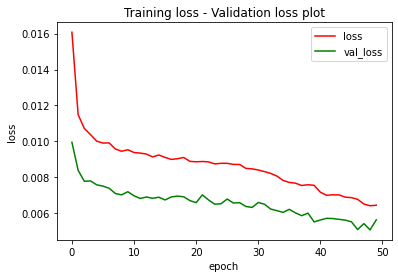

In [39]:
# loss 히스토리 확인
fig, loss_ax = plt.subplots()
loss_ax.plot(hist.history['loss'], 'r', label='loss')
loss_ax.plot(hist.history['val_loss'], 'g', label='val_loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend()
plt.title('Training loss - Validation loss plot')
plt.show()

In [40]:
# 저장된 가중치 불러오기
model.load_weights('baseline.h5')

In [42]:
# 테스트셋 전처리 및 추론
test_inputs = pd.read_csv('./farm/test_input.csv')
output_sample = pd.read_csv('./farm/answer_sample.csv')

test_inputs = test_inputs[inputs.columns]
test_inputs['주차'] = [int(i.replace('주차', "")) for i in test_inputs['주차']]
test_input_sc = input_scaler.transform(test_inputs.iloc[:,3:].to_numpy())

test_input_ts = []
for i in output_sample['Sample_no']:
    sample = test_input_sc[test_inputs['Sample_no'] == i]
    if len(sample < 7):
        sample = np.append(np.zeros((7-len(sample), sample.shape[-1])), sample,
                           axis=0)
    sample = np.expand_dims(sample, axis=0)
    test_input_ts.append(sample)
test_input_ts = np.concatenate(test_input_ts, axis=0)

In [44]:
test_input_ts.shape

(506, 7, 9)

In [46]:
prediction = model.predict(test_input_ts)

prediction = output_scaler.inverse_transform(prediction)
output_sample[['생장길이', '줄기직경', '개화군']] = prediction

16/16 [==============================] - 0s 793us/step


In [47]:
output_sample

,Sample_no,조사일,주차,생장길이,줄기직경,개화군
0,9,20220413,32주차,47.151882,7.198693,13.229403
1,12,20170312,30주차,420.956116,3.321363,10.489825
2,19,20170319,31주차,589.641235,4.079537,7.553223
3,23,20170326,32주차,281.593994,4.563877,7.977988
4,27,20170430,37주차,89.870880,7.789731,4.768530
...,...,...,...,...,...,...
501,2015,20160508,14주차,188.253265,12.274371,5.467629
502,2016,20160529,17주차,1998.461670,4.776089,1.905745
503,2024,20160828,7주차,49.577644,13.211569,2.025992
504,2025,20160828,7주차,49.577755,13.211572,2.025991


In [48]:
# 제출할 추론 결과 저장
output_sample.to_csv('prediction.csv', index=False)

`-` 텐서보드

In [53]:
# 학습
cb1 = tf.keras.callbacks.TensorBoard()
model.fit(train_x, train_y, batch_size=32, epochs=50, validation_data=(val_x, val_y), callbacks=[cb1])

Epoch 1/50
38/38 [==============================] - 0s 3ms/step - loss: 0.0062 - mse: 0.0062 - val_loss: 0.0049 - val_mse: 0.0049
Epoch 2/50
38/38 [==============================] - 0s 2ms/step - loss: 0.0063 - mse: 0.0063 - val_loss: 0.0052 - val_mse: 0.0052
Epoch 3/50
38/38 [==============================] - 0s 2ms/step - loss: 0.0064 - mse: 0.0064 - val_loss: 0.0051 - val_mse: 0.0051
Epoch 4/50
38/38 [==============================] - 0s 2ms/step - loss: 0.0062 - mse: 0.0062 - val_loss: 0.0049 - val_mse: 0.0049
Epoch 5/50
38/38 [==============================] - 0s 2ms/step - loss: 0.0060 - mse: 0.0060 - val_loss: 0.0051 - val_mse: 0.0051
Epoch 6/50
38/38 [==============================] - 0s 2ms/step - loss: 0.0058 - mse: 0.0058 - val_loss: 0.0046 - val_mse: 0.0046
Epoch 7/50
38/38 [==============================] - 0s 2ms/step - loss: 0.0060 - mse: 0.0060 - val_loss: 0.0048 - val_mse: 0.0048
Epoch 8/50
38/38 [==============================] - 0s 2ms/step - loss: 0.0058 - mse: 0.00

In [55]:
%load_ext tensorboard
%tensorboard --logdir logs --host 

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 109833), started 0:04:21 ago. (Use '!kill 109833' to kill it.)